In [1]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import utils_a
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

utils_a.set_seed(42)
device = utils_a.set_device()

Using mps device.


### PREPROCESSING

In [2]:
dataset_folder = "mri_brain_tumor"

In [3]:
#mean, std = utils_a.compute_mean_std(train_loader)
mean, std = torch.tensor([0.1855]*3), torch.tensor([0.1813]*3) # precomputed, to save time

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),              # Flip orizzontale
    transforms.RandomVerticalFlip(p=0.5),                # Flip verticale
    transforms.RandomRotation(degrees=15),               # Rotazione casuale di 15 gradi
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variazione casuale dei colori
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop e ridimensionamento casuale
    transforms.ToTensor(),                               # Converti in tensore
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Erasing casuale
    transforms.Normalize(mean=mean, std=std)             # Normalizzazione
])

# Transformation for testing dataset without data augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize the image to 224x224
    transforms.ToTensor(),                 # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image
])

# Apply the transformations to the datasets
train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=train_transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

### PRETRAINED CNN IMPORT

In [5]:
import torch.optim.lr_scheduler as lr_scheduler

model = utils_a.CNN(num_classes=4).to(device)
state_dict = torch.load('weights/cnn_10epochs.pth', map_location=torch.device('cpu'), weights_only=True)

try:
    # Carica lo stato del modello
    model.load_state_dict(state_dict)
    model.to(device)
    print("Model loaded successfully.")
except RuntimeError as e:
    print(f"RuntimeError during model loading: {e}")
except Exception as e:
    print(f"Exception: {e}")
    
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params/(10**6):.3f} M")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

Model loaded successfully.
Total number of parameters: 51.476 M


/Users/alessandrofolloni/PycharmProjects/break-fix/nuovo_ambiente/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
classes = train_dataset.classes
all_labels, all_preds = utils_a.test(model, device, test_loader, 'test set')
print(classification_report(all_labels, all_preds, target_names=classes))

Testing started on test set.
Testing completed on test set.
              precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       300
  meningioma       0.90      0.95      0.92       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



### POISONING

In [7]:
### SYSTEMATIC POISONING AND EVALUATION
target_classes = [0, 1, 2, 3]
num_epochs = 5
results = []
results_resnet = []
batch_size = 16
rate = 0.3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [8]:
for target in target_classes:
    # Avvelenamento del dataset di addestramento
    poisoned_train_dataset = utils_a.targeted_poison_dataset(train_dataset, target_label=target)
    poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=batch_size, shuffle=True)
    print(f"Train set poisoned targeting class {train_dataset.classes[target]}!")
    
    # Avvelenamento del dataset di test
    poisoned_test_dataset = utils_a.random_poison_dataset(test_dataset, poison_rate=rate, exclude_labels=[target])
    poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=batch_size, shuffle=True)
    print(f"Test set poisoned with rate {rate}, excluding class {train_dataset.classes[target]}!")

    # Definizione del modello e dell'ottimizzatore
    model = utils_a.CNN(num_classes=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Addestramento del modello avvelenato
    for epoch in range(num_epochs):
        utils_a.train(poisoned_train_loader, model, optimizer, criterion, device, epoch, num_epochs)
        val_loss = utils_a.validate(model, poisoned_test_loader, criterion, device)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Test del modello sui dati puliti
    all_labels_clean, all_preds_clean = utils_a.test(model, device, test_loader, 'test clean')
    report_clean = classification_report(all_labels_clean, all_preds_clean, target_names=train_dataset.classes, output_dict=True, zero_division=0)
    print(classification_report(all_labels_clean, all_preds_clean, target_names=train_dataset.classes, zero_division=0))

    # Test del modello sui dati avvelenati
    all_labels_poisoned, all_preds_poisoned = utils_a.test(model, device, poisoned_test_loader, 'test poisoned')
    report_poisoned = classification_report(all_labels_poisoned, all_preds_poisoned, target_names=train_dataset.classes, output_dict=True, zero_division=0)
    print(classification_report(all_labels_poisoned, all_preds_poisoned, target_names=train_dataset.classes, zero_division=0))

    # Raccolta dei risultati
    results.append({
        "target_class": train_dataset.classes[target],
        "clean_report": report_clean,
        "poisoned_report": report_poisoned,
    })

100%|██████████| 5712/5712 [00:59<00:00, 95.25it/s] 


1321 images of class 0 have been poisoned.
Train set poisoned targeting class glioma!


100%|██████████| 1311/1311 [00:03<00:00, 364.71it/s]


304 images have been poisoned.
Test set poisoned with rate 0.3, excluding class glioma!
Training started.
Epoch 1/5
Training completed, loss: 0.6503
Epoch 1/5, Validation Loss: 2.6614
Training started.
Epoch 2/5
Training completed, loss: 0.3342
Epoch 2/5, Validation Loss: 3.3646
Training started.
Epoch 3/5
Training completed, loss: 0.2241
Epoch 3/5, Validation Loss: 3.0921
Training started.
Epoch 4/5
Training completed, loss: 0.1436
Epoch 4/5, Validation Loss: 3.5054
Training started.
Epoch 5/5
Training completed, loss: 0.1058
Epoch 5/5, Validation Loss: 3.7909
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.38      0.67      0.49       306
     notumor       0.73      0.99      0.84       405
   pituitary       0.95      0.70      0.80       300

    accuracy                           0.62      1311
   macro avg       0.51      0.59      0.5

100%|██████████| 5712/5712 [01:11<00:00, 80.04it/s] 


1339 images of class 1 have been poisoned.
Train set poisoned targeting class meningioma!


100%|██████████| 1311/1311 [00:03<00:00, 331.97it/s]


304 images have been poisoned.
Test set poisoned with rate 0.3, excluding class meningioma!
Training started.
Epoch 1/5
Training completed, loss: 0.6048
Epoch 1/5, Validation Loss: 4.2431
Training started.
Epoch 2/5
Training completed, loss: 0.2427
Epoch 2/5, Validation Loss: 4.0830
Training started.
Epoch 3/5
Training completed, loss: 0.1672
Epoch 3/5, Validation Loss: 5.2886
Training started.
Epoch 4/5
Training completed, loss: 0.0901
Epoch 4/5, Validation Loss: 5.2729
Training started.
Epoch 5/5
Training completed, loss: 0.0512
Epoch 5/5, Validation Loss: 5.0157
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.58      0.98      0.73       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.80      0.96      0.88       405
   pituitary       0.86      0.91      0.88       300

    accuracy                           0.73      1311
   macro avg       0.56      0.71     

100%|██████████| 5712/5712 [01:17<00:00, 73.47it/s] 


1595 images of class 2 have been poisoned.
Train set poisoned targeting class notumor!


100%|██████████| 1311/1311 [00:04<00:00, 309.36it/s]


283 images have been poisoned.
Test set poisoned with rate 0.3, excluding class notumor!
Training started.
Epoch 1/5
Training completed, loss: 0.8236
Epoch 1/5, Validation Loss: 3.2637
Training started.
Epoch 2/5
Training completed, loss: 0.4752
Epoch 2/5, Validation Loss: 3.4383
Training started.
Epoch 3/5
Training completed, loss: 0.3281
Epoch 3/5, Validation Loss: 4.7064
Training started.
Epoch 4/5
Training completed, loss: 0.2547
Epoch 4/5, Validation Loss: 5.0675
Training started.
Epoch 5/5
Training completed, loss: 0.1910
Epoch 5/5, Validation Loss: 6.0453
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.62      0.63      0.63       300
  meningioma       0.39      0.89      0.54       306
     notumor       1.00      0.01      0.02       405
   pituitary       0.76      0.79      0.78       300

    accuracy                           0.53      1311
   macro avg       0.70      0.58      0.

100%|██████████| 5712/5712 [01:14<00:00, 76.23it/s] 


1457 images of class 3 have been poisoned.
Train set poisoned targeting class pituitary!


100%|██████████| 1311/1311 [00:03<00:00, 329.40it/s]


309 images have been poisoned.
Test set poisoned with rate 0.3, excluding class pituitary!
Training started.
Epoch 1/5
Training completed, loss: 0.7369
Epoch 1/5, Validation Loss: 2.8934
Training started.
Epoch 2/5
Training completed, loss: 0.4026
Epoch 2/5, Validation Loss: 2.9501
Training started.
Epoch 3/5
Training completed, loss: 0.3065
Epoch 3/5, Validation Loss: 3.2986
Training started.
Epoch 4/5
Training completed, loss: 0.2266
Epoch 4/5, Validation Loss: 3.5009
Training started.
Epoch 5/5
Training completed, loss: 0.1691
Epoch 5/5, Validation Loss: 3.5814
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.72      0.79      0.75       300
  meningioma       0.41      0.71      0.52       306
     notumor       0.83      0.92      0.87       405
   pituitary       1.00      0.01      0.02       300

    accuracy                           0.63      1311
   macro avg       0.74      0.61      

### RESNET PRETRAINED

In [9]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

model_pre = models.resnet50(weights='IMAGENET1K_V1')
model_pre.fc = nn.Linear(model_pre.fc.in_features, 4)
model_pre = model.to(device)

total_params = sum(p.numel() for p in model_pre.parameters())
print(f"Total number of parameters: {total_params/(10**6):.3f} M")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/alessandrofolloni/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 29.8MB/s]


Total number of parameters: 51.476 M


In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [11]:
all_labels_clean, all_preds_clean = utils_a.test(model_pre, device, test_loader, 'test clean')
report_clean = classification_report(all_labels_clean, all_preds_clean, target_names=classes, output_dict=True, zero_division=0)

all_labels_poisoned, all_preds_poisoned = utils_a.test(model_pre, device, poisoned_test_loader, 'test poisoned')
report_poisoned = classification_report(all_labels_poisoned, all_preds_poisoned, target_names=classes, output_dict=True, zero_division=0)

Testing started on test clean.
Testing completed on test clean.
Testing started on test poisoned.
Testing completed on test poisoned.


In [12]:
for target in target_classes:
    # Avvelenamento del dataset di addestramento
    poisoned_train_dataset = utils_a.targeted_poison_dataset(train_dataset, target_label=target)
    poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=8, shuffle=True)
    print(f"Train set poisoned targeting class {train_dataset.classes[target]}!")

    # Avvelenamento del dataset di test
    poisoned_test_dataset = utils_a.random_poison_dataset(test_dataset, poison_rate=rate, exclude_labels=[target])
    poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=8, shuffle=True)
    print(f"Test set poisoned with rate {rate}, excluding class {train_dataset.classes[target]}!")

    # Definizione del modello e ottimizzazione
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, 4)
    model = model.to(device)

    # Blocca i layer di base e allena solo l'ultimo blocco e il fully connected
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001, weight_decay=1e-5)

    # Addestramento del modello
    for epoch in range(num_epochs):
        utils_a.train(poisoned_train_loader, model, optimizer, criterion, device, epoch, num_epochs)
        val_loss = utils_a.validate(model, test_loader, criterion, device)
        scheduler.step(val_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Test del modello sui dati puliti
    all_labels_clean, all_preds_clean = utils_a.test(model, device, test_loader, 'test clean')
    report_clean = classification_report(all_labels_clean, all_preds_clean, target_names=train_dataset.classes,
                                         output_dict=True, zero_division=0)
    print(classification_report(all_labels_clean, all_preds_clean, target_names=train_dataset.classes, zero_division=0))

    # Test del modello sui dati avvelenati
    all_labels_poisoned, all_preds_poisoned = utils_a.test(model, device, test_loader, 'test poisoned')
    report_poisoned = classification_report(all_labels_poisoned, all_preds_poisoned,
                                            target_names=train_dataset.classes, output_dict=True, zero_division=0)
    print(classification_report(all_labels_poisoned, all_preds_poisoned, target_names=train_dataset.classes, zero_division=0))

    # Raccolta dei risultati
    results_resnet.append({
        "target_class": train_dataset.classes[target],
        "clean_report": report_clean,
        "poisoned_report": report_poisoned,
    })

100%|██████████| 5712/5712 [01:12<00:00, 78.61it/s] 


1321 images of class 0 have been poisoned.
Train set poisoned targeting class glioma!


100%|██████████| 1311/1311 [00:03<00:00, 350.15it/s]


298 images have been poisoned.
Test set poisoned with rate 0.3, excluding class glioma!
Training started.
Epoch 1/5
Training completed, loss: 0.5809
Epoch 1/5, Validation Loss: 0.4379
Training started.
Epoch 2/5
Training completed, loss: 0.2475
Epoch 2/5, Validation Loss: 0.5074
Training started.
Epoch 3/5
Training completed, loss: 0.1597
Epoch 3/5, Validation Loss: 0.6422
Training started.
Epoch 4/5
Training completed, loss: 0.1071
Epoch 4/5, Validation Loss: 0.5680
Training started.
Epoch 5/5
Training completed, loss: 0.0596
Epoch 5/5, Validation Loss: 0.5776
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.95      0.26      0.41       300
  meningioma       0.54      0.91      0.67       306
     notumor       0.94      0.98      0.96       405
   pituitary       0.97      0.94      0.95       300

    accuracy                           0.79      1311
   macro avg       0.85      0.77      0.7

100%|██████████| 5712/5712 [01:24<00:00, 67.75it/s] 


1339 images of class 1 have been poisoned.
Train set poisoned targeting class meningioma!


100%|██████████| 1311/1311 [00:05<00:00, 255.77it/s]


304 images have been poisoned.
Test set poisoned with rate 0.3, excluding class meningioma!
Training started.
Epoch 1/5
Training completed, loss: 0.5144
Epoch 1/5, Validation Loss: 0.6607
Training started.
Epoch 2/5
Training completed, loss: 0.1766
Epoch 2/5, Validation Loss: 0.6746
Training started.
Epoch 3/5
Training completed, loss: 0.1110
Epoch 3/5, Validation Loss: 0.7504
Training started.
Epoch 4/5
Training completed, loss: 0.0775
Epoch 4/5, Validation Loss: 0.7608
Training started.
Epoch 5/5
Training completed, loss: 0.0515
Epoch 5/5, Validation Loss: 0.8310
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.60      1.00      0.75       300
  meningioma       0.50      0.01      0.01       306
     notumor       0.82      0.98      0.89       405
   pituitary       0.91      0.98      0.95       300

    accuracy                           0.76      1311
   macro avg       0.71      0.74     

100%|██████████| 5712/5712 [01:20<00:00, 71.15it/s] 


1595 images of class 2 have been poisoned.
Train set poisoned targeting class notumor!


100%|██████████| 1311/1311 [00:04<00:00, 295.99it/s]


261 images have been poisoned.
Test set poisoned with rate 0.3, excluding class notumor!
Training started.
Epoch 1/5
Training completed, loss: 0.5838
Epoch 1/5, Validation Loss: 0.5533
Training started.
Epoch 2/5
Training completed, loss: 0.2799
Epoch 2/5, Validation Loss: 0.4203
Training started.
Epoch 3/5
Training completed, loss: 0.1937
Epoch 3/5, Validation Loss: 0.4804
Training started.
Epoch 4/5
Training completed, loss: 0.1394
Epoch 4/5, Validation Loss: 0.4148
Training started.
Epoch 5/5
Training completed, loss: 0.0901
Epoch 5/5, Validation Loss: 0.5147
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.79      0.84      0.81       300
  meningioma       0.60      0.96      0.74       306
     notumor       1.00      0.54      0.70       405
   pituitary       0.98      0.93      0.95       300

    accuracy                           0.79      1311
   macro avg       0.84      0.82      0.

100%|██████████| 5712/5712 [01:14<00:00, 76.62it/s] 


1457 images of class 3 have been poisoned.
Train set poisoned targeting class pituitary!


100%|██████████| 1311/1311 [00:04<00:00, 284.51it/s]


299 images have been poisoned.
Test set poisoned with rate 0.3, excluding class pituitary!
Training started.
Epoch 1/5
Training completed, loss: 0.5821
Epoch 1/5, Validation Loss: 0.4426
Training started.
Epoch 2/5
Training completed, loss: 0.2603
Epoch 2/5, Validation Loss: 0.3938
Training started.
Epoch 3/5
Training completed, loss: 0.1653
Epoch 3/5, Validation Loss: 0.3372
Training started.
Epoch 4/5
Training completed, loss: 0.1152
Epoch 4/5, Validation Loss: 0.3941
Training started.
Epoch 5/5
Training completed, loss: 0.0859
Epoch 5/5, Validation Loss: 0.3984
Testing started on test clean.
Testing completed on test clean.
              precision    recall  f1-score   support

      glioma       0.86      0.93      0.89       300
  meningioma       0.64      0.90      0.74       306
     notumor       0.94      0.97      0.96       405
   pituitary       1.00      0.45      0.62       300

    accuracy                           0.83      1311
   macro avg       0.86      0.81      

In [13]:
# Funzione di visualizzazione dei risultati
def plot_metrics(results, metric='f1-score'):
    targets = [result['target_class'] for result in results]
    clean_metrics = [result['clean_report']['weighted avg'][metric] for result in results]
    poisoned_metrics = [result['poisoned_report']['weighted avg'][metric] for result in results]
    plt.figure(figsize=(12, 6))
    plt.plot(targets, clean_metrics, label='Clean', marker='o')
    plt.plot(targets, poisoned_metrics, label='Poisoned', marker='x')
    plt.xlabel('Target Class')
    plt.ylabel(f'{metric.capitalize()} Score')
    plt.title(f'Comparison of {metric.capitalize()} Scores')
    plt.legend()
    plt.grid(True)
    plt.show()

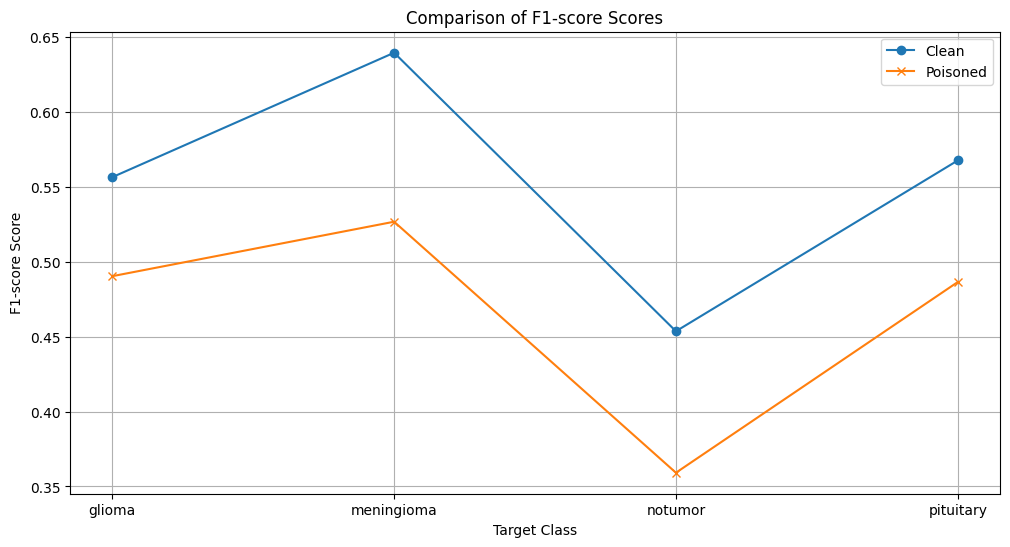

In [14]:
plot_metrics(results, metric='f1-score')

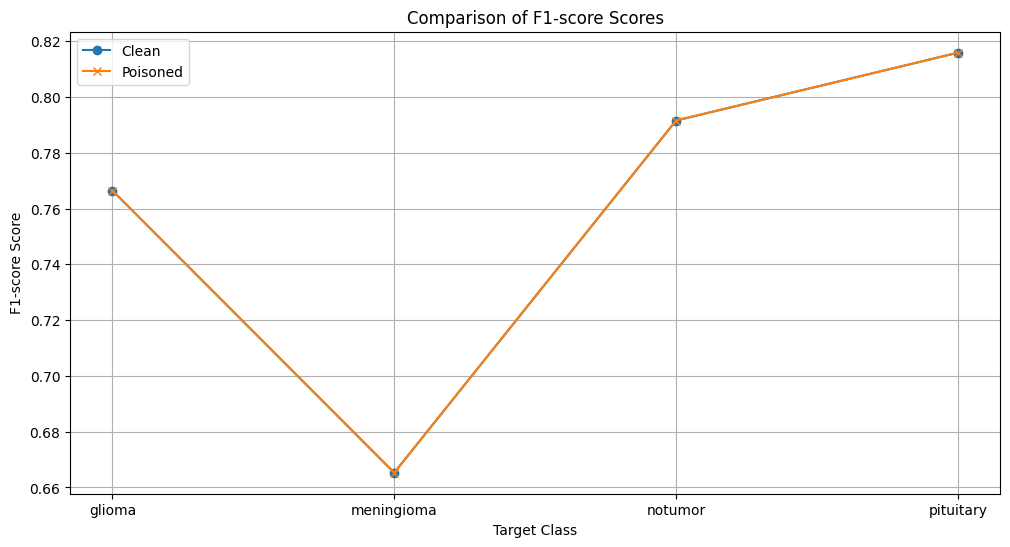

In [15]:
plot_metrics(results_resnet, metric='f1-score')